### Voxelize + ANN
Select a threshold density(size), above(below) which we use voxelize, then use ANN to fill in the rest of the cells.

In pseudocode:
```python
high_density_map = voxelize()
full_map = ann(
    data_points = particles,
    query_points = grid_points(Nsize = 512)
    )
```

In [2]:
%load_ext autoreload
%autoreload 2
from vpower.interp import SimulationParticles
import vpower.voxelize
Nsize = 256
radii_threshold = 1.                             # np.min(allPar.h())
# 1 for all voxelize, 0 for no voxelize

SNAPSHOT = '/appalachia/d5/DISK/from_pleiades/snapshots/gmcs0_wind0_gmc9/snapshot_550.hdf5'
inputParticles = SimulationParticles.load_snapshot(SNAPSHOT, remove_bulk_velocity=False)

denseParticles = inputParticles[inputParticles.h() <= radii_threshold]
voxelizeField = denseParticles.voxelize_interp_to_field(Nsize=Nsize)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Interpolating velocity field...
Padding:  0.035411309549151726 Lbox:  1.0708226190983035 Nsize:  274
Auto padding done. Time elapsed: 2.53 s


OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
root_add_process : started ...
workers_process : started ...
workers using 35 threads.
Workers processed 86407227 numbers, of which were
	0.000e+00 exact calculations (R<Rmin),
	8.066e+07 exact calculations (R>Rmax),
	5.748e+06 trivial calculations,
	0.000e+00 interpolations.

workers_process : ended.
Root processed 86407227 numbers in 2654 CPU-chunks.
root_add_process : ended.
voxelize_gpu function took 12.4104 seconds
In the end, 0 in cpu_queue
/appalachia/d6/yujie/Test_PowerSpec/vpower/voxelize.py:108: RuntimeWarning: invalid value encountered in divide
  v_grid = vec_grid[..., :3] / vec_grid[..., 3, None]     # divide by mass


Interpolation done. Time elapsed: 19.66 s


In [3]:
annField = inputParticles.ann_interp_to_field(Nsize=Nsize, overwrite=True)

Interpolating velocity field...
Box length: 1.0, box size: 256
Data file saved. Time taken: 34.95 s
Query file saved. Time taken: 56.24 s



real	1m21.914s
user	1m19.942s
sys	0m1.736s


Approximate Nearest Neighbour complete. Time taken: 82.10 s.
ANN output read. Time taken: 8.04 s
Interpolation done. Time elapsed: 188.21 s


In [8]:
# Combination
from vpower.interp import SimulationField3D
import numpy as np
density_threshold = np.nanpercentile(voxelizeField.get_density(), 10.0)
print(density_threshold)

condition = np.isnan(voxelizeField.get_data()) | (voxelizeField.get_density() < density_threshold)[..., None]
array = np.where(condition, annField, voxelizeField)
outputField = SimulationField3D(array[..., :3], array[..., 3], annField.Lcell)

1.3621473158309527e-06


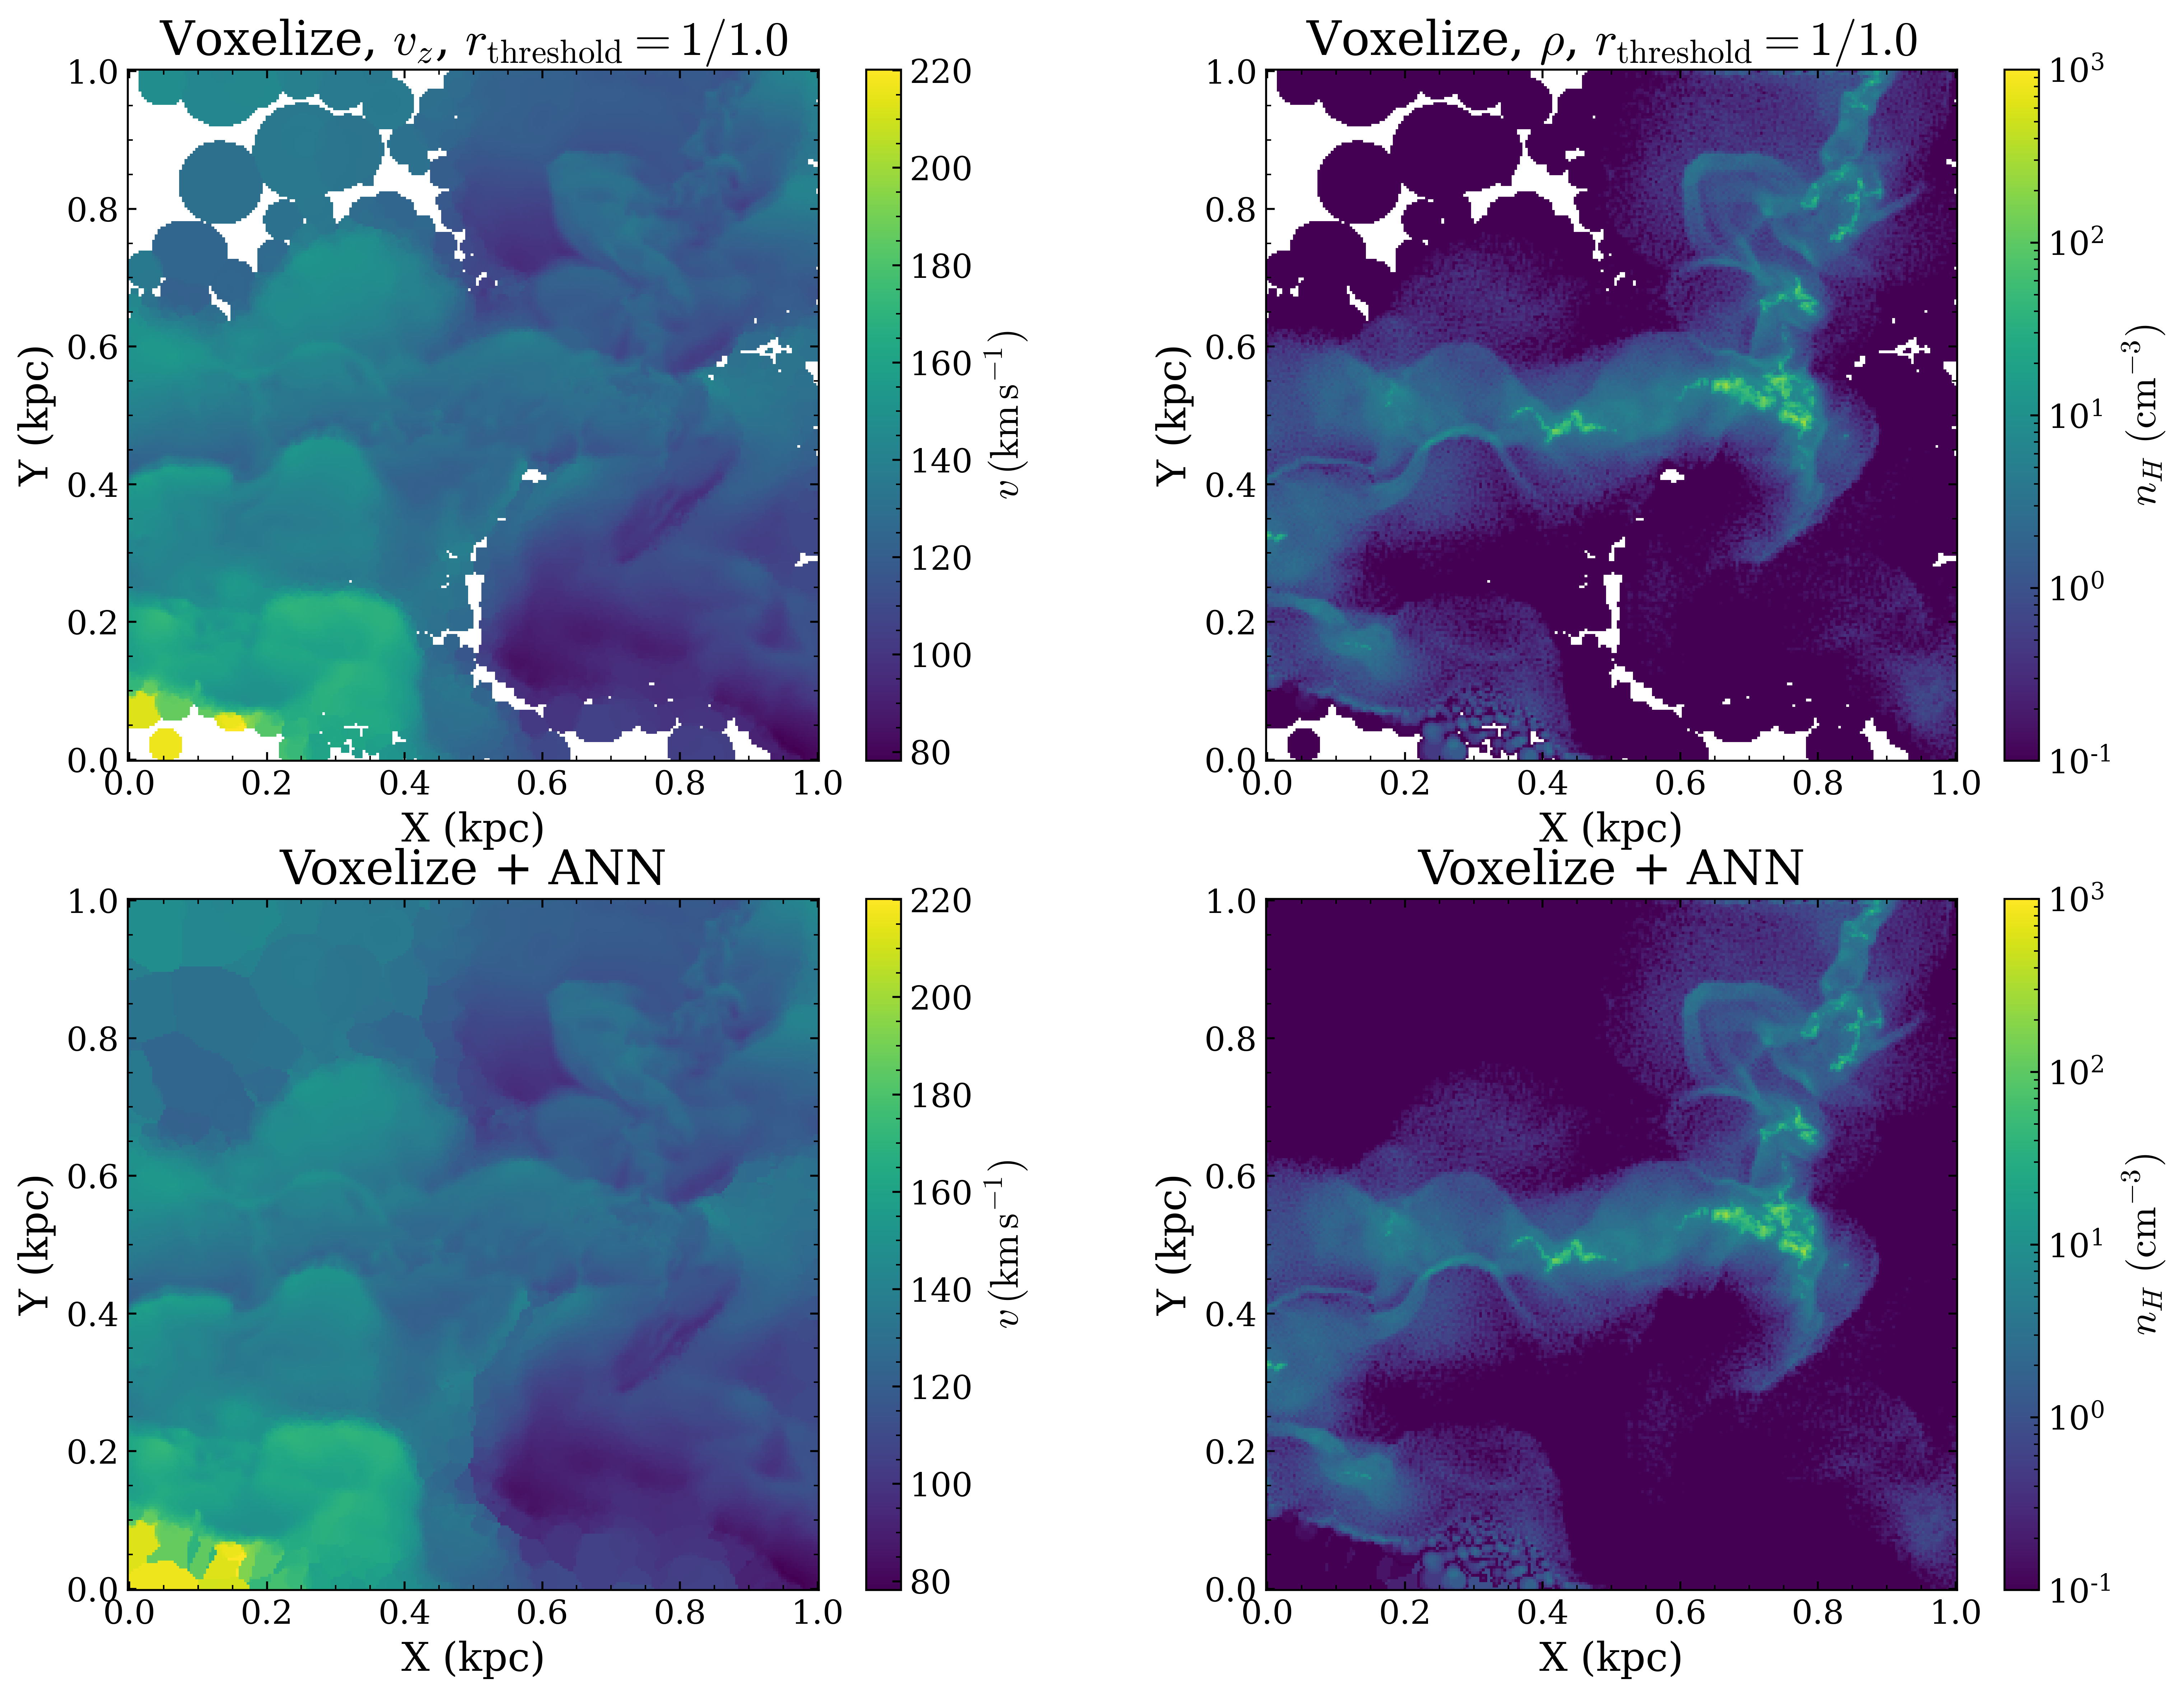

In [9]:
import matplotlib.pyplot as plt
plt.style.use('nice.mplstyle')

fig, ax = plt.subplots(2, 2, figsize=(15, 11), dpi=500)

voxelizeField.plot_velocity_slice(component=0, index=voxelizeField.Nsize//2, axis=2, ax=ax[0,0])
ax[0,0].set_title("Voxelize, $v_z$, $r_\\mathrm{{threshold}}=1/{}$".format(1/radii_threshold))

outputField.plot_velocity_slice(component=0, index=outputField.Nsize//2, axis=2, ax=ax[1,0])
ax[1,0].set_title("Voxelize + ANN")

voxelizeField.plot_density_slice(index=voxelizeField.Nsize//2, axis=2, ax=ax[0,1])
ax[0,1].set_title("Voxelize, $\\rho$, $r_\\mathrm{{threshold}}=1/{}$".format(1/radii_threshold))

outputField.plot_density_slice(index=outputField.Nsize//2, axis=2, ax=ax[1,1])
ax[1,1].set_title("Voxelize + ANN")
plt.show()

Test conservation, for different density thresholds and different resolutions. 
- Conserved to what percentage? 
- How does it change with free parameters? 
- How does it change with resolution?

In [10]:
from vpower.interp import check_conservation
check_conservation(inputParticles, outputField)

Total mass of particles: 1.260e-03
Total mass after interpolation: 1.263e-03
Total mass restored by 100.231%


Total momentum of particles: [ 0.16640169  0.2250191  -0.00676618]
Total momentum after interpolation: [ 0.16701904  0.22565282 -0.00675334]
Total momentum restored by (100.371%, 100.282%, 99.810%)


Total kinetic energy of particles: 3.141e+01
Total kinetic energy after interpolation: 3.154e+01
Total kinetic energy restored by 100.404%


Least 10% density, radii threshold = 1.
| Resolution | Mass restored | Momentum restored | Kinetic energy restored |
|------------|---------------|-------------------|-------------------------|
| 256        |  100.231%  | (100.371%, 100.282%, 99.810%) |   100.404%   |

##### 70\% filled cells use voxelize, rest use ANN
| Radii threshold | Resolution | Mass restored | Momentum restored | Kinetic energy restored |
|-----------------|------------|---------------|-------------------|-------------------------|
| 1/256 | 256 | 98.484% | (98.404%, 98.459%, 98.791%) | 98.376% |
| 1/512 | 512 | 100.867% | (100.818%, 100.849%, 101.010%) | 100.786% |

##### 100\% filled cells use voxelize, rest use ANN
| Radii threshold | Resolution | Mass restored | Momentum restored | Kinetic energy restored |
|-----------------|------------|---------------|-------------------|-------------------------|
| 1/512 | 256 | 99.861% | (99.748%, 99.830%, 99.835%) | 99.719% |
| 1/512 | 512 | 102.037% | (101.999%, 102.024%, 102.045%) | 101.968% |
##### Combination by 'maximize'
| Radii threshold | Density threshold | Resolution | Mass restored | Momentum restored | Kinetic energy restored |
|-----------------|-------------------|------------|---------------|-------------------|-------------------------|
| 1/512   |         10x       | 256        | 109.099%      | (108.639%, 109.045%, 109.235%) | 108.632%       |
##### Combination by 'stitching'
| Radii threshold | Density threshold | Resolution | Mass restored | Momentum restored | Kinetic energy restored |
|-----------------|-------------------|------------|---------------|-------------------|-------------------------|
| 0.0 (ANN only)   |         10x       | 256        | 98.497%       | (98.429%, 98.457%, 98.103%) | 98.384%       |
| 0.0 (ANN only)   |         10x       | 512        | 98.600%       | (98.551%, 98.574%, 98.895%) | 98.521%       |
| 1/512           |         10x       | 256        | 98.876%       | (98.787%, 98.850%, 99.157%) | 98.758%       |
| 1/512           |         10x       | 512        | 103.780%      | (103.863%, 103.768%, 103.970%) | 103.796%   |
| 1/256           |         10x       | 256        | 100.253%      | (100.291%, 100.189%, 100.700%) | 100.186%   |
| 1/256           |         10x       | 512        | 101.865%      | (101.919%, 101.770%, 102.362%) | 101.779%   |
| 1.0 (Voxelize mostly) |         10x       | 256        | 100.023%      | (100.012%, 100.015%, 99.549%) | 99.998%     |
| 1.0 (Voxelize mostly) |         10x      | 512        | 100.212%      | (100.196%, 100.202%, 99.720%) | 100.187%    |